# Final Project
In this final project I will be using data collected at the remote observing room for the Nickel 1-m telescope at the Lick Observatory in San Jose. On February 26, 2025 I took images of asteroids in the night sky with the goals of calculating the proper motion of the asteroid using the method of least squares. Along with this calcualtion I will be querying data from the US Naval Observatory (USNO-B1) star catalog to measure the plate constants of the telescope. I will break down each section of code with descriptions and equations to help guide you through the process of this project. Attached is a utils.py file that will house the important functions of this project, and descriptions of those functions are written in that file.

In [1]:
import glob
from importlib import reload

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u

import utils as ut

plt.rcParams.update({'font.size': 13})

%matplotlib inline
pm = "\u00B1"  # plus-minus symbol for use in uncertainties

# set to false before submission to change default cmap
DARK = False
if DARK:
    cdef = 'gray'
    cdef_r = 'gray_r'
else:
    cdef = 'gray_r'
    cdef_r = 'gray'

In [2]:
reload(ut)

<module 'utils' from '/Users/parkergeorge/UCSD/Phys41/Phys41/utils.py'>

## 1. Data Reduction
### 1a. Read in Data and Headers
Before beginning data reduction, files are read in and separated based on file type for easy organization.

In [3]:
# Load in our data
files = glob.glob('final_project_data/*')
ut.ascend_str(files, (-8,-5))
used_files = []

In [4]:
# Set a name slice for future use
name_slice = slice(-10,-5)

In [5]:
# Sorting our frames
bias_frames = files[81:]
used_files.extend(bias_frames)

Vflat_files = files[17]
used_files.append(Vflat_files)

Rflat_files = files[19:23]
used_files.extend(Rflat_files)

V60terpsichore = files[75:78]
R60terpsichore = files[78:81]

used_files.extend(V60terpsichore)
used_files.extend(R60terpsichore)

bias_frames, Vflat_files, Rflat_files, V60terpsichore, R60terpsichore

(['final_project_data/d1354.fits',
  'final_project_data/d1355.fits',
  'final_project_data/d1356.fits',
  'final_project_data/d1357.fits',
  'final_project_data/d1358.fits',
  'final_project_data/d1359.fits',
  'final_project_data/d1360.fits',
  'final_project_data/d1361.fits',
  'final_project_data/d1362.fits',
  'final_project_data/d1363.fits',
  'final_project_data/d1364.fits'],
 'final_project_data/d1017.fits',
 ['final_project_data/d1019.fits',
  'final_project_data/d1020.fits',
  'final_project_data/d1021.fits',
  'final_project_data/d1022.fits'],
 ['final_project_data/d1075.fits',
  'final_project_data/d1076.fits',
  'final_project_data/d1077.fits'],
 ['final_project_data/d1078.fits',
  'final_project_data/d1079.fits',
  'final_project_data/d1080.fits'])

The header of the files house important information regarding the positions of the asteroids at the time the iamge was taken as well as the exposure time of the image that we will use later on in our evaluation.

In [6]:
# Read the Headers from our files
used_file_names = [used_file[-10:] for used_file in used_files]
headers = ['OBSTYPE', 'OBJECT', 'DATE-BEG', 'RA', 'DEC', 'RADECSYS', 'EXPTIME', 'FILTNAM', 'COVER', 'AIRMASS']
header_data = ut.load_headers_all_files(headers, used_files)
df = pd.DataFrame({h: d for h, d in zip(headers, header_data)})
df.insert(0, 'FILE NAME', used_file_names)
df['DATE-BEG'] = Time(df['DATE-BEG'].astype(str).tolist(), format='isot', scale='utc').decimalyear
df.style.format(precision=8).hide()

print(df)

     FILE NAME OBSTYPE       OBJECT     DATE-BEG           RA         DEC  \
0   d1354.fits    DARK         Bias  2025.157480  13:56:37.26  38:18:54.9   
1   d1355.fits    DARK         Bias  2025.157481  13:57:12.58  38:18:54.2   
2   d1356.fits    DARK         Bias  2025.157482  13:57:42.72  38:18:53.8   
3   d1357.fits    DARK         Bias  2025.157483  13:58:17.91  38:18:53.2   
4   d1358.fits    DARK         Bias  2025.157484  13:58:48.17  38:18:52.6   
5   d1359.fits    DARK         Bias  2025.157485  13:59:18.30  38:18:52.1   
6   d1360.fits    DARK         Bias  2025.157486  13:59:53.50  38:18:51.5   
7   d1361.fits    DARK         Bias  2025.157487  14:00:23.75  38:18:51.0   
8   d1362.fits    DARK         Bias  2025.157488  14:00:58.95  38:18:50.4   
9   d1363.fits    DARK         Bias  2025.157489  14:01:29.09  38:18:49.9   
10  d1364.fits    DARK         Bias  2025.157490  14:02:04.28  38:18:49.3   
11  d1017.fits  OBJECT        VFlat  2025.156575  05:57:08.68  -5:10:18.4   

### 1b. Reduce Bias and Flat frames
A master bias frame is created to remove the base illumination of the CCD from the images. Dome-Flats (images with a constant illumination) are used to normalize our science images so that the intensity values are all less than 1. A couple of bad columns of pixels are removed that throw off our analysis of the stars in the images later in the project.

In [7]:
# Removing overscan & removing bad pixel columns for bias and flats
bad_cols = [255, 256, 1002]
master_bias = ut.remove_bad_cols(ut.my_bias(bias_frames), bad_cols)
Vflat_clean = ut.remove_bad_cols(ut.load_frame_overscan_remove_bias_subtract(Vflat_files, master_bias), bad_cols)
Rflat_clean = ut.remove_bad_cols(ut.my_avg(ut.load_frame_overscan_remove_bias_subtract(Rflat_files, master_bias)), bad_cols)

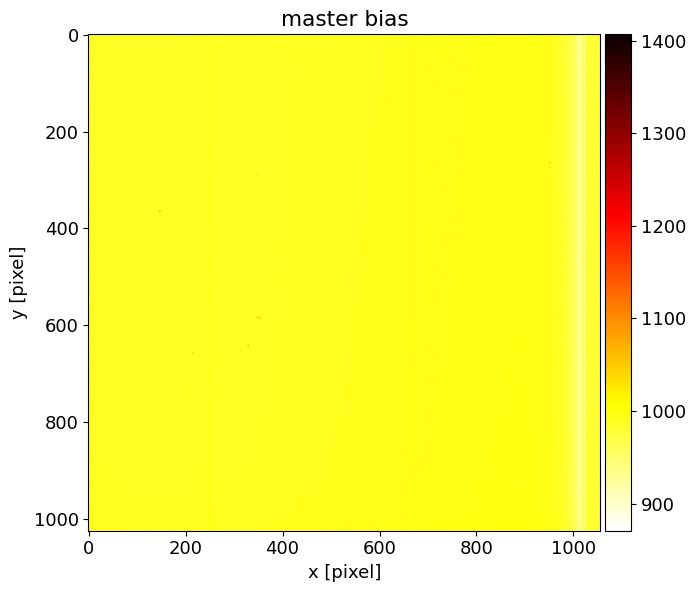

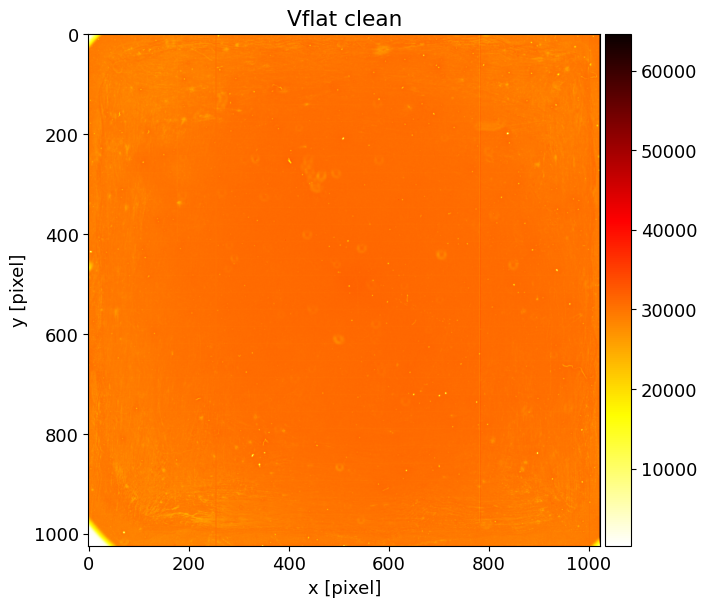

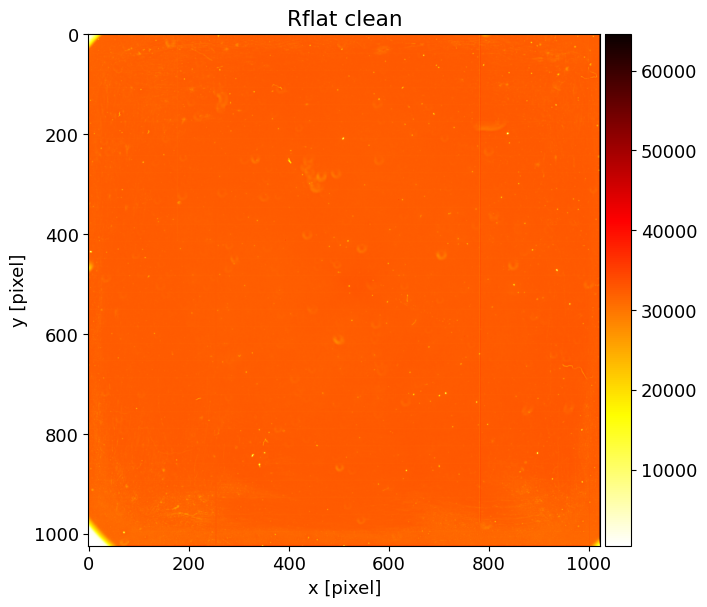

In [8]:
# Test the Bias and Flats
fig1, ax1 = plt.subplots(figsize=[7,7])
fig2, ax2 = plt.subplots(figsize=[7,7])
fig3, ax3 = plt.subplots(figsize=[7,7])
ut.plot_im(ax1, master_bias, cmap='hot_r', title='master bias')
ut.plot_im(ax2, Vflat_clean, cmap='hot_r', title='Vflat clean')
ut.plot_im(ax3, Rflat_clean, cmap='hot_r', title='Rflat clean')

### 1c. Reduce Science Frames
Due to the spread of stars in the image, 81 Terpsichore is selected for further analysis. We do the same process of reduction and normalization as before, as well as the removal of bad pixel columns. The R-band filter is chosen for further analysis due to its slightly higher intensity counts over the V-band, making it easier to analyze down the line.

In [9]:
Vterpsichore = [ut.remove_bad_cols(frame, bad_cols) for frame in ut.load_reduced_science_frame(V60terpsichore, Vflat_clean, master_bias)]
Rterpsichore = [ut.remove_bad_cols(frame, bad_cols) for frame in ut.load_reduced_science_frame(R60terpsichore, Rflat_clean, master_bias)]
print(Vterpsichore)

[array([[0.05178973, 0.0907764 , 0.0579644 , ..., 0.00701593, 0.00513552,
        0.00444632],
       [0.02184869, 0.03652264, 0.04045898, ..., 0.00438809, 0.00435339,
        0.00424337],
       [0.02413514, 0.03443275, 0.04114682, ..., 0.00504207, 0.00491989,
        0.00475792],
       ...,
       [0.02570257, 0.03296598, 0.02573054, ..., 0.00491994, 0.005291  ,
        0.00372062],
       [0.00678487, 0.02612814, 0.01912659, ..., 0.00635336, 0.00560448,
        0.00385191],
       [0.02324471, 0.02722705, 0.02015888, ..., 0.00570677, 0.00437421,
        0.00458911]], shape=(1024, 1024)), array([[0.05178973, 0.09340414, 0.04562359, ..., 0.00856408, 0.00483662,
        0.00475092],
       [0.01746567, 0.02431143, 0.04159721, ..., 0.00557033, 0.00487214,
        0.00424337],
       [0.01811504, 0.02651836, 0.0246506 , ..., 0.00430746, 0.00457298,
        0.00454127],
       ...,
       [0.02570257, 0.05841341, 0.05254448, ..., 0.00491994, 0.0063708 ,
        0.00476501],
       [0.026

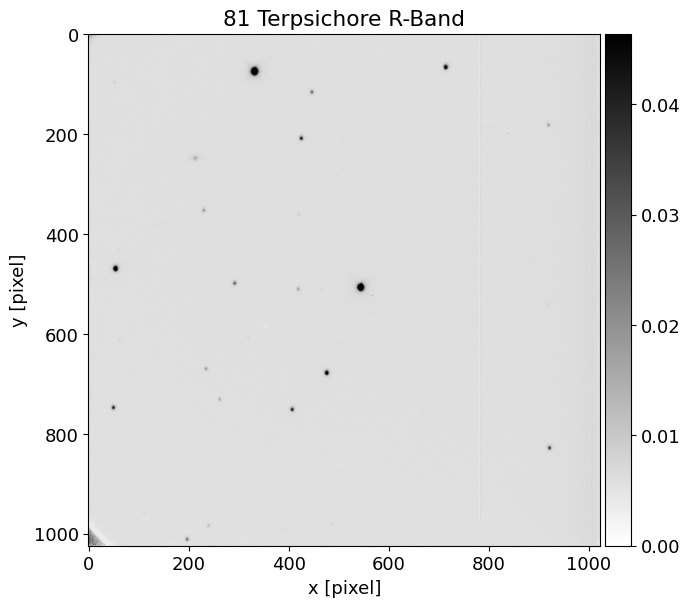

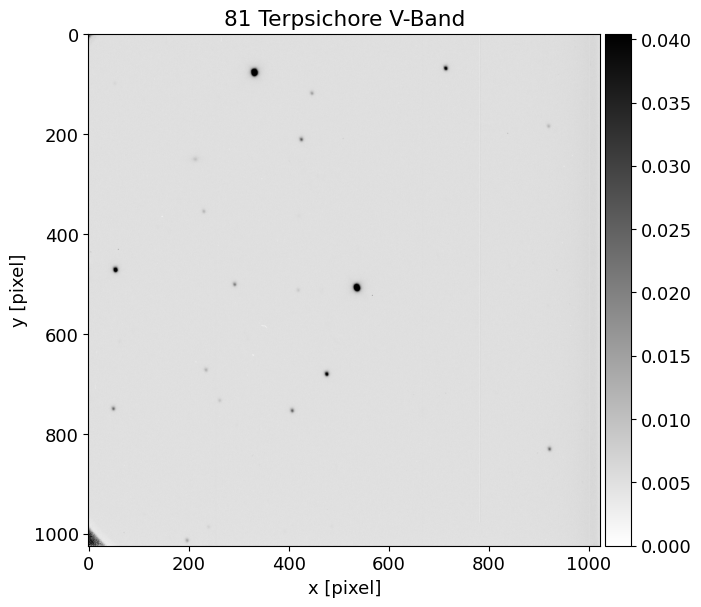

In [10]:
chosen_frame = np.median(Rterpsichore, axis=0)
other_frame = np.median(Vterpsichore, axis=0)
chosen_file = R60terpsichore[0][-10:]
fig4, ax4 = plt.subplots(figsize=[7,7])
fig5, ax5 = plt.subplots(figsize=[7,7])
ut.plot_im(ax4, chosen_frame, cmap=cdef, vmax=8*np.median(chosen_frame), title='81 Terpsichore R-Band')
ut.plot_im(ax5, other_frame, cmap=cdef, vmax=8*np.median(other_frame), title='81 Terpsichore V-Band')


## 2. Comparison With Digital Sky Survey
### 2a. Choose Science Frame and Compute x and y positions using the USNO B-1 Catalog
The stars in the image are found using a 2-D centroid function. After setting the parameters, they are adjusted to find a balanced number of stars in the image, and manually checked in case a hot pizel was picked up instead of a star. The asteroid location is also removed and set aside for analysis later in the project and so as not to interfere with our calculation of the telescopes plate scale.
$$\langle p \rangle = \left(\frac{\sum{x_i I_{p_i}}}{\sum{I_{p_i}}}, \frac{\sum{y_i I_{p_i}}}{\sum{I_{p_i}}} \right),$$
$$\sigma_{\langle p \rangle} = \left(\frac{\sum{_j I_{p_j}\left(x_j-\langle x \rangle \right)^2}}{\left(\sum{I_{p_i}}\right)^2}, \frac{\sum{_j I_{p_j}\left(y_j-\langle y \rangle \right)^2}}{\left(\sum{I_{p_i}}\right)^2} \right).$$

In [11]:
window_size = 10    # inspect 10 pixels ahead
background_factor = 1.5     # multiplier of median to discern bright pixels
bright_px_ratio = 0.5   # need 50% to be above background_factor times above the median
bright_count_thresh = int(bright_px_ratio * window_size)    # get number of pixels ratio correlates to
window_max = window_size * 2    # set window size for centroid algorithm
star_locs = ut.find_star_locs(chosen_frame, n_size=window_size, bright_count_thresh=bright_count_thresh, background_factor=background_factor)
pos_arr = ut.make_pos_array(chosen_frame)
centroids_list = ut.calc_centroids_2d(chosen_frame, pos_arr, star_locs, window_max=window_max)

# determined by inspection, 9 is asteroid, and -1 has no star match
asteroid_centroid = centroids_list[9]
centroids_list = np.delete(centroids_list, [9, -1], axis=0)
print(asteroid_centroid)
print(centroids_list)

[505 545 np.float64(1.1718734468554262) np.float64(1.1518402033502713)]
[[65 715 np.float64(2.429971825838092) np.float64(2.42437869159396)]
 [74 334 np.float64(1.053539495856472) np.float64(1.0555969075026812)]
 [115 449 np.float64(2.9070381704789385) np.float64(3.1005149388867452)]
 [181 921 np.float64(3.3336501766763855) np.float64(3.34479009254882)]
 [209 428 np.float64(2.7583353307915033) np.float64(2.772267709272293)]
 [249 214 np.float64(3.1985820755241576) np.float64(3.109195035719912)]
 [351 231 np.float64(3.325350322438966) np.float64(3.3339474530892867)]
 [469 55 np.float64(1.840999163532538) np.float64(1.9739528579819574)]
 [498 291 np.float64(3.0309196025953296) np.float64(3.004790381551285)]
 [510 420 np.float64(3.418455923849533) np.float64(3.4147851562887803)]
 [670 235 np.float64(3.3827155584267468) np.float64(3.21942031405682)]
 [678 478 np.float64(2.1402484197252916) np.float64(2.12204252964543)]
 [730 264 np.float64(3.5008243240625108) np.float64(3.378306698559566)]

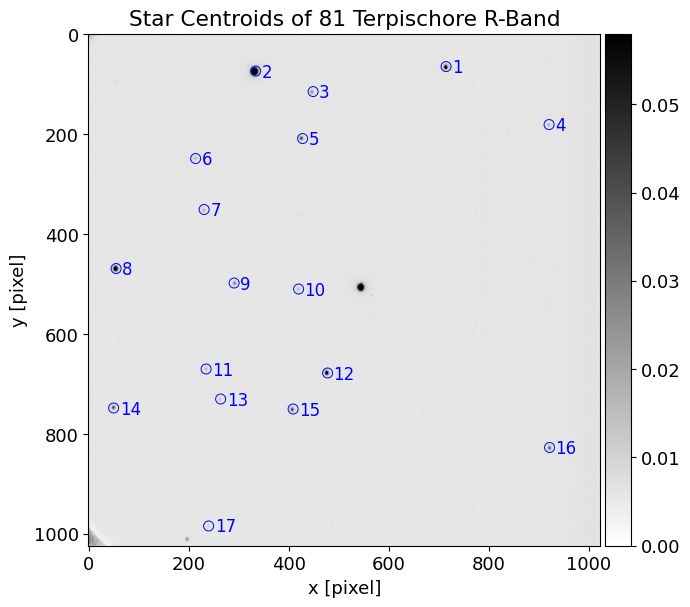

In [12]:

fig6, ax6 = plt.subplots(figsize=[7, 7])
ut.plot_im(ax6, chosen_frame, cmap=cdef, vmax=10 * np.median(chosen_frame), title='Star Centroids of 81 Terpischore R-Band')

for i, (y, x) in enumerate(centroids_list[:, :2], start=1):
    # set radius
    r = 10

    # make circle patch
    circ = patches.Circle((x, y), radius=r, edgecolor='blue', facecolor='none', lw=0.7)
    ax6.add_patch(circ)
    ax6.text(x + r + 2, y + r + 2, str(i), color='blue', fontsize=12)

Since the stars from the catalog will be in units of Right Ascension and Declination, a coordinate transformation needs to occur to have both sets of stars in x,y pixel. This process is explained in the following equations,

$$\begin{aligned}
		X = - \frac{\cos\delta \sin\left(\alpha - \alpha_0\right)}{\cos\delta_0 \cos\delta \cos\left(\alpha - \alpha_0\right) + \sin\delta \sin\delta_0}\\
		Y = - \frac{\sin\delta_0 \cos\delta \cos\left(\alpha - \alpha_0\right) - \cos\delta_0 \sin\delta}{\cos\delta_0 \cos\delta \cos\left(\alpha - \alpha_0\right) + \sin\delta \sin\delta_0},
		\end{aligned}$$

$$\begin{aligned}
		x = f\left(\frac{X}{p}\right) + x_0 \\
		y = f\left(\frac{Y}{p}\right) + y_0,
		\end{aligned}$$
where $f$ is the focal length of the camera and $p$ is the pixel size.



In [13]:
magnitude_limit = 18
fov_width  = '6.3m'
fov_height = '6.3m'
focal_length = 16480    # in mm
pixel_size = 0.015*2    # in mm, 2x binning
plate_scale = 0.184*2   # as/px, 2x binning

In [14]:
# set the RA and DEC using sky_query
ra_cat, dec_cat, center_coord = ut.sky_query(df, chosen_file, fov_width, fov_height, magnitude_limit)
x, y = ut.local_pixel_size(ra_cat, dec_cat, center_coord, focal_length, pixel_size)

# determined by inspection, no centroid match
x = np.delete(x, 4)
y = np.delete(y, 4)

# determined by inspection, centering correction
delta_x = -45
delta_y = 15
x += delta_x
y += delta_y

# invert y to correct for origin
y = 1024-y

x, y

(array([418.6892548 , 929.19297093, 482.64198949,  68.40185459,
        274.95887501, 244.69417214,  58.63520897, 421.12192788,
        294.96261201, 228.34908296, 205.55970403, 433.34211049,
        415.37643257, 317.82321866, 903.14555481, 695.52319455]),
 array([749.95279758, 805.36627849, 675.16980421, 757.11849854,
        734.19517898, 675.416019  , 485.27086661, 512.31183653,
        504.60855266, 363.17233117, 260.31179928, 121.26059284,
        213.70411139,  85.69979988, 168.14062866,  61.96689451]))

### 2b. Compute the Centroids of the Stars in our Image

### 2c. Cross-Correlate Stars in Image With USNO B-1 Catalog
Now that both sets of stars are in x,y pixels they can be overlayed and we can perform a least squares fit to extract the plate scale of the telescope.

Text(0, 0.5, 'y [pixel]')

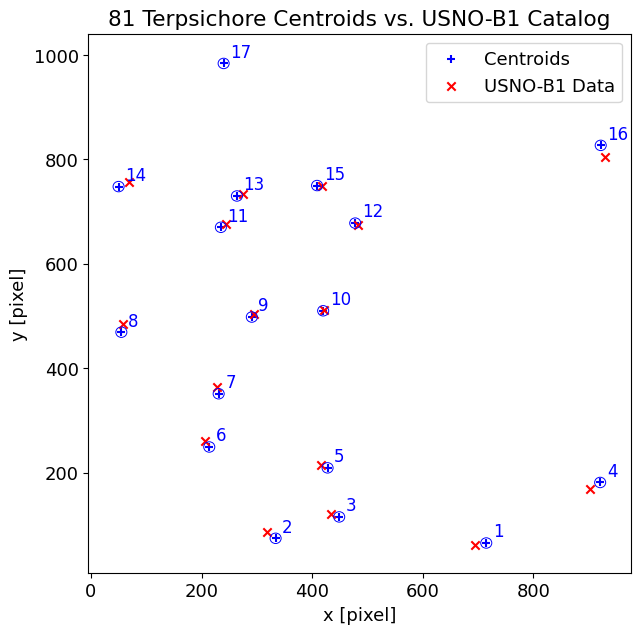

In [15]:
fig7, ax7 = plt.subplots(figsize=[7,7])
#ut.plot_im(ax6, chosen_frame, cmap=cdef, vmax=10*np.median(chosen_frame))

# account for upper left origin by reflecting y-axis
ax7.scatter(centroids_list[:, 1], centroids_list[:, 0], c='b', marker='+', label='Centroids')
ax7.scatter(x, y, c='r', label='USNO-B1 Data', marker='x')


for i, (cy, cx) in enumerate(centroids_list[:, :2], start=1):
    # set radius
    r = 10

    # make circle patch
    circ = patches.Circle((cx, cy), radius=r, edgecolor='blue', facecolor='none', lw=0.7)
    ax7.add_patch(circ)
    ax7.text(cx + r+2, cy + r+2, str(i), color='blue', fontsize=12)

ax7.legend()
ax7.set_title('81 Terpsichore Centroids vs. USNO-B1 Catalog')
ax7.set_xlabel('x [pixel]')
ax7.set_ylabel('y [pixel]')

## 3. Method of Least Squares

### 3a. Coordinate transformation
From the previous image we can see the rotational nature of the stars in our image contrasted with the stars from the catalog, this rotation needs to be accounted for when changing coordinates properly and performing the fit.

$$\begin{aligned}
		x = \frac{f}{p}\left(X\cos\theta - Y\sin\theta \right) + x_0 \\
		y = \frac{f}{p}\left(X\sin\theta - Y\cos\theta \right) + y_0,
		\end{aligned}$$

In [16]:
X, Y = ut.local_pixel_size(ra_cat, dec_cat, center_coord, standard=True)

# determined by inspection, no centroid match
X = np.delete(X, 4)
Y = np.delete(Y, 4)

# invert x, y changes determined by inspection
X += delta_x * pixel_size/focal_length
Y += delta_y * pixel_size/focal_length
X, Y

(array([-1.69861793e-04,  7.59453224e-04, -5.34429803e-05, -8.07520896e-04,
        -4.31506902e-04, -4.86600415e-04, -8.25299984e-04, -1.65433384e-04,
        -3.95092333e-04, -5.16354825e-04, -5.57840345e-04, -1.43187906e-04,
        -1.75892416e-04, -3.53477150e-04,  7.12036811e-04,  3.34083485e-04]),
 array([-4.33166500e-04, -5.34040556e-04, -2.97032411e-04, -4.46210859e-04,
        -4.04481515e-04, -2.97480617e-04,  4.86574030e-05, -5.67663581e-07,
         1.34553046e-05,  2.70924154e-04,  4.58170268e-04,  7.11297464e-04,
         5.43014360e-04,  7.76031918e-04,  6.25957593e-04,  8.19235022e-04]))

In [17]:
ax = centroids_list[:, 1]
ay = centroids_list[:, 0]

standard_coords = np.column_stack([X, Y])
catalog_coords = np.column_stack([x, y])
centroid_coords = np.column_stack([ax, ay])

# align arrays by nearest neighbor
matches = ut.nearest_neighbor_match(catalog_coords, centroid_coords)

a_order = [pair[0] for pair in matches]
b_order = [pair[1] for pair in matches]

standard_ordered = standard_coords[a_order]
catalog_ordered = catalog_coords[a_order]
centroid_ordered = centroid_coords[b_order]

X, Y = standard_ordered.T
x, y = catalog_ordered.T
ax, ay = centroid_ordered.T

To solve for $\chi^2$ we set up the matrix equation,

$$\mathbf{x} = \mathbf{T}\mathbf{X},$$

where $\mathbf{x}$ and $\mathbf{X}$ are vector spaces and $\mathbf{T}$ is,

$$\mathbf{T} = \begin{pmatrix}
(f/p)a_{11} & (f/p)a_{12} & x_0 \\
(f/p)a_{21} & (f/p)a_{22} & y_0 \\
0 & 0 & 1
\end{pmatrix}.$$

The constants $a_{ij}$ refer to the scale, shear, and orientation of the image, while $x_0$ and $y_0$ refer to pointing offsets in pixels. Putting this in matrix form for both x and y we have,

$$ \mathbf{a}_x = \begin{pmatrix} x_1 \\ x_2 \\ \vdots \\ x_N \end{pmatrix} = \begin{pmatrix} (f/p)X_1 & (f/p)Y_1 & 1 \\ (f/p)X_2 & (f/p)Y_2 & 1 \\ \vdots & \vdots & \vdots \\ (f/p)X_N & (f/p)Y_N & 1 \end{pmatrix} \begin{pmatrix} a_{11} & a_{12} & x_0 \end{pmatrix} = \mathbf{B}\mathbf{c}_x, \\ $$

$$ \mathbf{a}_y =
			\begin{pmatrix}
			y_1 \\ y_2 \\ \vdots \\ y_N
			\end{pmatrix}
			=
			\begin{pmatrix}
			(f/p)X_1 & (f/p)Y_1 & 1 \\
			(f/p)X_2 & (f/p)Y_2 & 1 \\
			\vdots & \vdots & \vdots \\
			(f/p)X_N & (f/p)Y_N & 1
			\end{pmatrix}
			\begin{pmatrix}
			a_{21} & a_{22} & y_0
			\end{pmatrix} = \mathbf{B}\mathbf{c}_y. $$

$\chi^2$ then becomes,

$$ \chi^2 = \frac{\left(\mathbf{a} - \mathbf{Bc}\right)^T\mathbf{\left(\mathbf{a} - \mathbf{Bc}\right)}}{N-p}, $$

where we can solve for $\mathbf{c}$ in terms of $\mathbf{B}$ and $\mathbf{a}$,

$$ \mathbf{c} = (\mathbf{B}^T \mathbf{B})^{-1}\mathbf{B}^T \mathbf{a}. $$


In [18]:
B = np.column_stack([focal_length/pixel_size * X, focal_length/pixel_size * Y, np.ones_like(X)])
B_coeff = np.matmul(np.linalg.inv(np.matmul(B.T, B)), B.T)

cx = np.matmul(B_coeff, ax)
cy = np.matmul(B_coeff, ay)

residual_x = ax - np.matmul(B, cx)
residual_y = ay - np.matmul(B, cy)
chi_sq_x = np.matmul(residual_x.T, residual_x)/(len(residual_x)-len(cx))
chi_sq_y = np.matmul(residual_y.T, residual_y)/(len(residual_y)-len(cy))
print(chi_sq_x)
print(chi_sq_y)
print(cx)
print(cy)

2.229854872115332
1.267195296204733
[1.0116334957669346 0.041405751139089675 512.1470236995934]
[0.037475467858687085 -1.0130868598558387 513.9438109626567]


In [19]:
T = np.array([[focal_length/pixel_size * cx[0], focal_length/pixel_size * cx[1], cx[2]],
              [focal_length/pixel_size * cy[0], focal_length/pixel_size * cy[1], cy[2]],
              [0, 0, 1]])
print(T)

[[ 5.55724000e+05  2.27455593e+04  5.12147024e+02]
 [ 2.05865237e+04 -5.56522382e+05  5.13943811e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


After solving for the plate constants, the plate scale (and corresponding error) then becomes,

$$ f/p = \sqrt{\det(\mathbf{T})}. $$
$$ \sigma_S \approx \sqrt{\det(\mathbf{T})}\frac{\chi}{L}, $$

where $L$ is the length of the image and $\chi$ is the star positions.

In [20]:
# RMS is chi
rms_x = np.sqrt(chi_sq_x)
rms_y = np.sqrt(chi_sq_y)

# scale converted to as/px
scale = np.sqrt(np.abs(np.linalg.det(T))) * np.pi/180 * 1/3600
scale = 1/scale

# image dimensions
L = 1024

# x, y errors
sig_x = scale * rms_x/L
sig_y = scale * rms_y/L

# assuming isotropic conditions, which is not true
sig = np.sqrt(sig_x**2 + sig_y**2)

scale, sig

(np.float64(0.3706173254426333), np.float64(0.0006768254681923537))

In [21]:
x_new, y_new, ones = np.matmul(T, np.stack([X, Y, np.ones_like(X)]))

# Mean Absolute Percentage Error (MAPE)
def mape(g, t):
    return np.mean(np.abs((g - t)/t)*100)

print(mape(x_new, ax))
print(mape(y_new, ay))

0.6658447062021122
0.2697148976810111


Text(0.5, 1.0, '81 Terpsichore Centroids vs. USNO-B1 Catalog (least squares fit)')

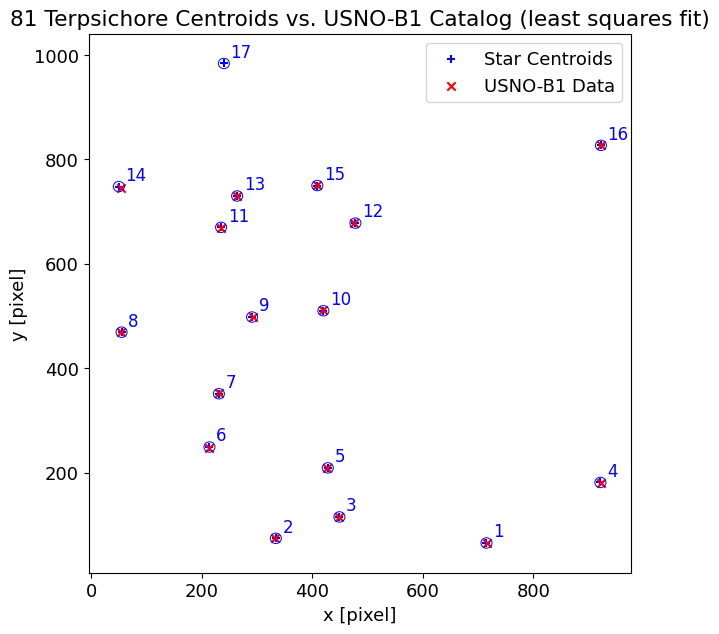

In [22]:
fig8, ax8 = plt.subplots(figsize=[7,7])
# ut.plot_im(ax7, chosen_frame, cmap=cdef, vmax=10*np.median(chosen_frame))

# account for upper left origin by reflecting y-axis
ax8.scatter(centroids_list[:, 1], centroids_list[:, 0], c='b', marker='+', label='Star Centroids')
ax8.scatter(x_new, y_new, c='r', label='USNO-B1 Data', marker='x')


for i, (cy, cx) in enumerate(centroids_list[:, :2], start=1):
    # set radius
    r = 10

    # make circle patch
    circ = patches.Circle((cx, cy), radius=r, edgecolor='blue', facecolor='none', lw=0.7)
    ax8.add_patch(circ)
    ax8.text(cx + r+2, cy + r+2, str(i), color='blue', fontsize=12)

ax8.legend()
ax8.set_xlabel('x [pixel]')
ax8.set_ylabel('y [pixel]')
ax8.set_title('81 Terpsichore Centroids vs. USNO-B1 Catalog (least squares fit)')

## 4. Asteroid Proper Motion
After testing the fit, it is time to go ahead and use a similar method to calculate the proper motion of the asteroid, but instead of transforming coordinates from x,y pixel to RA and DEC, we need to do the reverse, where we take the x,y pixel location of the star and compute the RA and DEC over time as follows,

$$\mathbf{X} = \mathbf{T}^{-1}\mathbf{x},$$
$$\alpha = arctan \left(-\frac{X}{\cos\delta_0 - Y \sin\delta_0}\right) + \alpha_0,$$
$$\delta = arcsin \left( \frac{\sin\delta_0 + Y \cos\delta_0}{\sqrt{1 + X^2 + Y^2}}\right),$$
$$\begin{aligned}
		\sigma_\alpha \approx \frac{\sigma_X}{\cos\delta_0}, \\
		\sigma_\delta \approx \sigma_Y
		\end{aligned},$$

where for our error propagation we assume that X,Y << 1 to simplify their calculations.


In [23]:
terpsichore = np.concatenate((Vterpsichore, Rterpsichore), axis=0)

In [24]:
window_size = 10    # inspect 10 pixels ahead
background_factor = 3     # multiplier of median to discern bright pixels
bright_px_ratio = 0.5   # need 50% to be above background_factor times above the median
bright_count_thresh = int(bright_px_ratio * window_size)    # get number of pixels ratio correlates to
window_max = window_size * 3    # set window size for centroid algorithm


asteroid_pos_local = ut.zeros(len(terpsichore), dtype=np.float64)
for i, frame in enumerate(terpsichore):
    star_locs = ut.find_star_locs(frame, n_size=window_size, bright_count_thresh=bright_count_thresh, background_factor=background_factor)
    pos_arr = ut.make_pos_array(frame)
    centroids_list = ut.calc_centroids_2d(frame, pos_arr, star_locs, window_max=window_max)

    # find the closest centroid to middle of image
    matches = ut.nearest_neighbor_match([[512, 512]], centroids_list[:, :2])
    idx = matches[0][1]     # grab centroid list idx that matches
    asteroid_pos_local[i] = centroids_list[idx]

asteroid_pos_local

[array([507, 536, np.float64(1.0421263673053973),
        np.float64(1.010151170736114)], dtype=object),
 array([506, 538, np.float64(1.060376952127498),
        np.float64(0.9672180146052636)], dtype=object),
 array([506, 539, np.float64(1.115583193190617),
        np.float64(1.0104027205280344)], dtype=object),
 array([505, 543, np.float64(0.7964768851294104),
        np.float64(0.7706480332403846)], dtype=object),
 array([506, 545, np.float64(0.7806125818846174),
        np.float64(0.7642055771699021)], dtype=object),
 array([506, 547, np.float64(0.8358862722399838),
        np.float64(0.7993537340769302)], dtype=object)]

In [25]:
dataframe = df
mask = dataframe['OBJECT'] == 'Terpsichore'
ra_center, dec_center, yrs = dataframe.loc[mask, ['RA', 'DEC', 'DATE-BEG']].values.T

center_coord = SkyCoord(ra=ra_center[0], dec=dec_center[0], unit=(u.hour, u.deg), frame='fk5')

# convert to radians
ra_0 = center_coord.ra.value * np.pi/180
dec_0 = center_coord.dec.value * np.pi/180

# convert yrs to hours and subtract starting year
yrs = np.asarray(yrs, dtype=np.float64)
yrs = yrs * 24 * 365.25
yrs = yrs - yrs[0]

ra_0, dec_0

(np.float64(2.3584074222397695), np.float64(0.43650733073746295))

In [26]:
inv_T = np.linalg.inv(T)
asteroid_pos = ut.zeros(len(asteroid_pos_local), dtype=np.float64)
for i, (x, y, xerr, yerr) in enumerate(asteroid_pos_local):
    # convert from pixels to standard coords
    X, Y, one = np.matmul(inv_T, np.array([x, y, 1]))
    Xerr, Yerr, one = np.matmul(inv_T, np.array([xerr, yerr, 1]))

    # get ra and dec of asteroid and convert to as
    ra = (np.arctan2(-X, (np.cos(dec_0) - Y * np.sin(dec_0))) + ra_0) * 180/np.pi * 3600
    dec = np.arcsin((np.sin(dec_0) + Y * np.cos(dec_0))/np.sqrt(1 + X**2 + Y**2)) * 180/np.pi * 3600

    # use err approximations and convert to as
    sig_a = np.abs(Xerr/np.cos(dec_0)) * 180/np.pi * 3600
    sig_d = np.abs(Yerr) * 180/np.pi * 3600
    asteroid_pos[i] = np.array((ra, dec, sig_a, sig_d), dtype=np.float64)

asteroid_pos

[array([4.86458186e+05, 9.00278671e+04, 2.17588827e+02, 1.82815254e+02]),
 array([4.86458562e+05, 9.00271132e+04, 2.17582081e+02, 1.82831392e+02]),
 array([4.86458545e+05, 9.00267431e+04, 2.17558783e+02, 1.82816168e+02]),
 array([4.86458887e+05, 9.00252492e+04, 2.17693288e+02, 1.82900519e+02]),
 array([4.86458445e+05, 9.00245227e+04, 2.17699883e+02, 1.82902686e+02]),
 array([4.86458411e+05, 9.00237826e+04, 2.17676692e+02, 1.82890437e+02])]

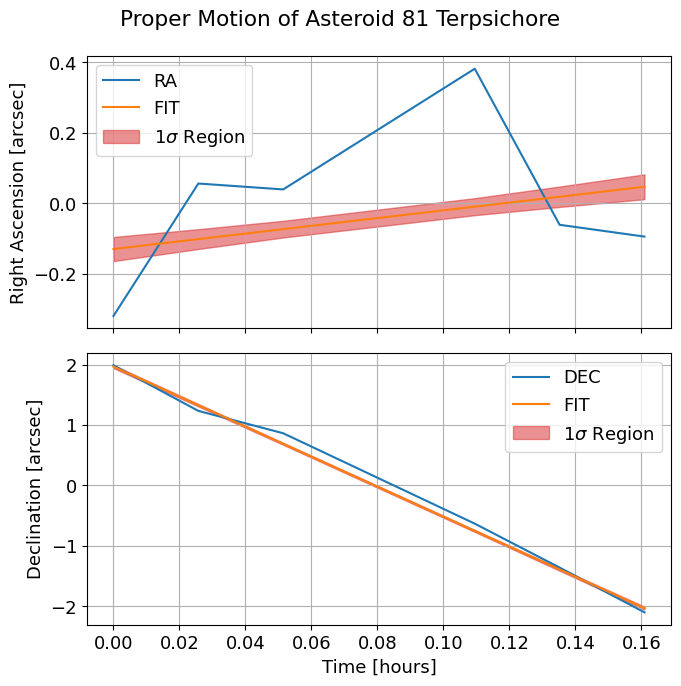

In [27]:
ra_arr = [pos[0] for pos in asteroid_pos]
dec_arr = [pos[1] for pos in asteroid_pos]
ra_err_arr = [pos[2] for pos in asteroid_pos]
dec_err_arr = [pos[3] for pos in asteroid_pos]

# removing means to prevent error washing (both change very slowly with respect to time)
ra_arr = ra_arr - ut.my_avg(ra_arr)
ra_err_arr = ra_err_arr - ut.my_avg(ra_err_arr)
dec_arr = dec_arr - ut.my_avg(dec_arr)
dec_err_arr = dec_err_arr - ut.my_avg(dec_err_arr)

# linear least squares with uncertainties as weights
ra_m, ra_c, ra_cov = ut.linear_least_squares(yrs, ra_arr, ra_err_arr)
dec_m, dec_c, dec_cov = ut.linear_least_squares(yrs, dec_arr, dec_err_arr)

# get 1 sigma region
ra_err = ut.get_1_sigma_region(yrs, ra_cov)
dec_err = ut.get_1_sigma_region(yrs, dec_cov)

# perform fit
ra_y_fit = ra_m*yrs + ra_c
dec_y_fit = dec_m*yrs + dec_c

# graph
fig9, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(7, 7))

# top
ax1.plot(yrs, ra_arr, label='RA')
ax1.plot(yrs, ra_y_fit, label='FIT')
ax1.fill_between(yrs, ra_y_fit - ra_err, ra_y_fit + ra_err, color='tab:red', alpha=0.5, label=r'$1\sigma$ Region')
ax1.set_ylabel('Right Ascension [arcsec]')
ax1.legend()
ax1.grid()

# bottom
ax2.plot(yrs, dec_arr, label='DEC')
ax2.plot(yrs, dec_m*yrs + dec_c, label='FIT')
ax2.fill_between(yrs, dec_y_fit - dec_err, dec_y_fit + dec_err, color='tab:red', alpha=0.5, label=r'$1\sigma$ Region')
ax2.set_ylabel('Declination [arcsec]')
ax2.set_xlabel('Time [hours]')
ax2.legend()
ax2.grid()

plt.suptitle("Proper Motion of Asteroid 81 Terpsichore")
plt.tight_layout()
plt.show()

To achieve the total motion of the asteroid with respect to some angle, the following equations are used,

$$ v = \sqrt{\alpha^2 + \delta^2}, $$
$$ \theta = \arctan \frac{\delta}{\alpha}. $$

wehre v is in units of as/hr and $\theta$ is in units of degrees. Our calculated values are,

$$ v \approx 24.378 \pm 0.04 as/hr, $$
$$ \theta \approx 268.95 \pm 0.0012, $$

Therefore, the asteroid is moving South-East as shown in the final image with the arrow showing the direction of motion of the asteroid.

In [28]:
length = (ra_m**2 + dec_m**2)**0.5
ra_m, dec_m, length

(np.float64(1.0966079738345107),
 np.float64(-24.802388572523938),
 np.float64(24.826619341963244))

Text(790, 982, 'E')

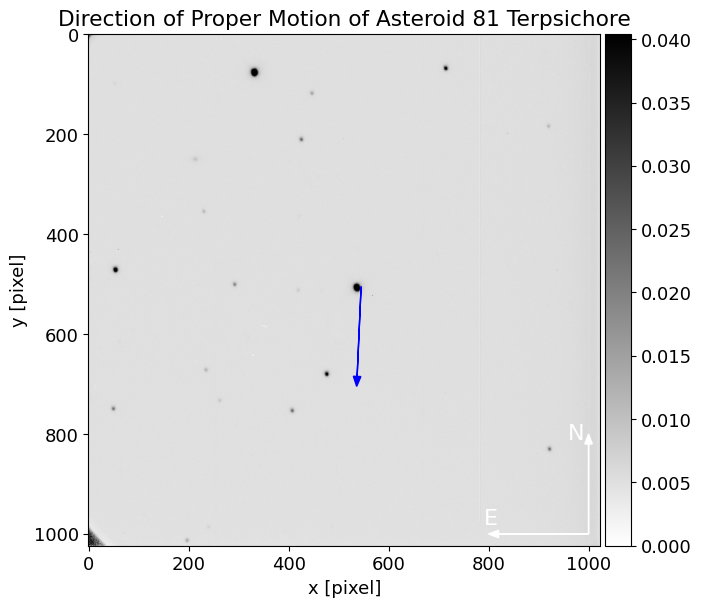

In [29]:
chosen_frame = np.median(Vterpsichore, axis=0)
fig10, ax10 = plt.subplots(figsize=[7,7])
ut.plot_im(ax10, chosen_frame, cmap=cdef, vmax=8*np.median(chosen_frame), title=('Direction of Proper Motion of Asteroid 81 Terpsichore'))

# add proper motion arrow
ax10.arrow(
    asteroid_centroid[1],
    asteroid_centroid[0],
    -200*ra_m/length,
    -200*dec_m/length,
    head_width=15,         # adjust as needed
    head_length=20,        # adjust as needed
    fc='b', ec='b',         # facecolor & edgecolor
    length_includes_head=True
)

# add cardinal directions
# north
ax10.arrow(
    1000,
    1000,
    0,
    -200,
    head_width=15,         # adjust as needed
    head_length=20,        # adjust as needed
    fc='white', ec='white',         # facecolor & edgecolor
    length_includes_head=True
)
ax10.text(
    958,
    810,
    'N',
    fontsize=16,
    color='white'
)

# east
ax10.arrow(
    1000,
    1000,
    -200,
    0,
    head_width=15,         # adjust as needed
    head_length=20,        # adjust as needed
    fc='white', ec='white',         # facecolor & edgecolor
    length_includes_head=True
)
ax10.text(
    790,
    982,
    'E',
    fontsize=16,
    color='white'
)

